### Import Library yang Dibutuhkan

In [2]:
import pandas as pd
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import squarify
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from sklearn.preprocessing import MinMaxScaler

### Baca Data

In [3]:
df = pd.read_csv('Dataset/ecommerce_data.csv', encoding='utf-8')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6.0,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8.0,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6.0,12/1/2010 8:26,3.39,17850.0,United Kingdom


### Statistik Deskriptif 

In [37]:
df.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID,TotalPrice
count,535874.000000,535874,535874.000000,403182.000000,535874.000000
mean,9.587927,2011-07-04 21:02:24.878534656,4.636533,15287.687868,18.066343
min,-74215.000000,2010-12-01 08:26:00,-11062.060000,12346.000000,-77183.600000
25%,1.000000,2011-03-28 13:28:00,1.250000,13952.000000,3.480000
50%,3.000000,2011-07-20 12:58:00,2.080000,15152.000000,9.840000
75%,10.000000,2011-10-19 12:11:00,4.130000,16791.000000,17.400000
max,74215.000000,2011-12-09 12:50:00,38970.000000,18287.000000,77183.600000
std,153.292222,NaN,97.302232,1714.009551,197.929775


Melalui tabel deskriptif statistik maka dapat dilakukan pengecekan **outlier** dan juga nilai maksimal minimal tiap atribut, nilai rata-rata dan variansi juga cukup berpengaruh terhadap pengolahan data pada prediksi.

### Membuat Atribut Total Price

In [4]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

$$
\text{TotalPrice} = \text{Quantity} \times \text{UnitPrice}
$$

**Total Price** adalah variabel yang mewakili jumlah total harga untuk suatu produk atau transaksi. 

### Konversi Tipe Data

In [5]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

tipe data **Invoice Date** dkonversi menjadi tipe data tanggal dan waktu yang awalnya bertipe data objek.

### Membuat Tabel RFM 

In [51]:
today_date = datetime.datetime(2011, 12, 11)

rfm = df.groupby("CustomerID").agg({"InvoiceDate": lambda x: (today_date - x.max()).days,
                               "InvoiceNo": lambda x: x.nunique(),
                               "TotalPrice": lambda x: x.sum()})

rfm.columns = ["recency", "frequency", "monetary"]

rfm = rfm[rfm["monetary"] > 0]
rfm.head()

,recency,frequency,monetary
CustomerID,,,
12347.0,3,7,4299.80
12348.0,76,4,1797.24
12349.0,19,1,1757.55
12350.0,311,1,334.40
12352.0,37,11,1545.41


Tabel RFM dibuat dengan menghitung tingkat recency, frequency, dan juga monetary dari masing-masing customer. Dataframe baru dibuat dengan menggabungkan komponen-komponen tadi lalu mengganti nama kolom atribut yang sesuai dengan konteks tabel dan melakukan filter bagi customer dengan tingkat monetary yang bernilai minus.

#### 1. Recency

$$
\text{Recency} = \text{Today Date} - \text{Invoice Date}
$$

Recency mengukur seberapa baru pelanggan terakhir kali melakukan transaksi. Untuk menghitung recency, kita mengambil selisih antara tanggal terakhir transaksi pelanggan dengan tanggal referensi yang ditentukan.

#### 2. Frequency

$$
\text{Frequency} = \text{Total} \space \text{Unique} \space \text{Number}
$$

Frequency mengukur seberapa sering pelanggan melakukan transaksi dalam periode waktu tertentu. Untuk menghitung frequency, kita menghitung jumlah transaksi yang dilakukan oleh pelanggan selama periode waktu yang ditentukan.

#### 3. Monetary

$$
\text{Monetary} = \text{Total} \space \text{of} \space \text{Total} \space \text{Price}
$$

Monetary mengukur total nilai pembelian yang dilakukan oleh pelanggan selama periode waktu tertentu. Untuk menghitung monetary, kita menjumlahkan total nilai transaksi atau pendapatan yang dihasilkan oleh pelanggan dalam periode waktu yang ditentukan.

### Melabeli Skor Recency, Frequency, Monetary

In [53]:
rfm["recency_score"] = pd.qcut(rfm['recency'], 5, labels=[5, 4, 3, 2, 1])

rfm["frequency_score"] = pd.qcut(rfm['frequency'].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])

rfm["monetary_score"] = pd.qcut(rfm['monetary'], 5, labels=[1, 2, 3, 4, 5])

Dilakukan Pelabelan untuk masing-masing skor **Recency**, **Frequency**, dan **Monetary** dengan interval 1 hingga 5 agar dapat dikelompokkan sesuai segmen masing-masing.

### Menghitung skor RFM

In [55]:
rfm["RFM_SCORE"] = (rfm['recency_score'].astype(str) + rfm['frequency_score'].astype(str))

$$
\text{RFM Score} = \text{Recency} \space \text{Score} + \text{Frequency} \space \text{Score}
$$

Untuk mengetahui skor RFM masing-masing customer maka dilakukan kalkulasi dengan menjumlahkan **Recency Score** dan juga **Frequency Score**, kedua skor tersebut dijumlahkan untuk menghitung skor RFM disebabkan karena kita ingin mengatahui skor RFM customer dari seberapa baru pengguna juga tingkat frekuensi pengguna dalam transaksi.

In [58]:
seg_map = {
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at_Risk',
    r'[1-2]5': 'cant_loose',
    r'3[1-2]': 'about_to_sleep',
    r'33': 'need_attention',
    r'[3-4][4-5]': 'loyal_customers',
    r'41': 'promising',
    r'51': 'new_customers',
    r'[4-5][2-3]': 'potential_loyalists',
    r'5[4-5]': 'champions'
}


rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex=True)

rfm[["segment", "recency", "frequency", "monetary"]].groupby("segment").agg(["mean", "count"])

recency        frequency           monetary      
                           mean count       mean count         mean count
segment                                                                  
about_to_sleep        52.250000   360   1.300000   360   437.376472   360
at_Risk              156.156766   606   3.344884   606   964.778403   606
cant_loose           132.300000    70   9.771429    70  2365.759857    70
champions              6.083460   659  14.672231   659  6507.434370   659
hibernating          213.451208  1035   1.207729  1035   396.841450  1035
loyal_customers       32.669677   775   8.061935   775  2718.713188   775
need_attention        49.240223   179   2.675978   179   820.826034   179
new_customers          7.238095    42   1.000000    42   374.408571    42
potential_loyalists   16.573737   495   2.246465   495   716.404525   495
promising             23.187500    96   1.000000    96   304.855104    96

### Segmentasi Customer Berdasarkan RFM
1. **Hibernanting**: Segmen ini mencakup pelanggan yang belum melakukan pembelian terakhir dan memiliki frekuensi pembelian yang rendah. Mereka mungkin memerlukan upaya yang ditargetkan untuk melibatkan kembali dan mengaktifkannya kembali.

2. **At Risk**: Pelanggan di segmen ini telah melakukan pembelian baru-baru ini tetapi berisiko mengalami churn karena frekuensi yang menurun. Penting untuk mengambil tindakan proaktif untuk mempertahankan dan melibatkan mereka kembali.

3. **Can't Loose**: Pelanggan ini telah melakukan pembelian baru-baru ini dan memiliki frekuensi pembelian yang tinggi. Mereka berharga dan harus diperlakukan sebagai pelanggan setia yang menghasilkan pendapatan yang konsisten.

4. **About To Sleep**: Pelanggan di segmen ini memiliki resensi sedang tetapi frekuensi pembeliannya rendah. Mereka berisiko menjadi tidak aktif, jadi upaya harus dilakukan untuk melibatkan mereka kembali dan mencegah mereka tergelincir ke dalam segmen 'hibernasi'.

5. **Need Attention**: Pelanggan ini memiliki keterkinian sedang dan membutuhkan perhatian. Perilaku mereka menunjukkan potensi penurunan keterlibatan, dan tindakan proaktif harus diambil untuk memenuhi kebutuhan mereka dan mempertahankannya.

6. **Loyal Customer**: Segmen ini terdiri dari pelanggan setia dengan keterkinian sedang dan frekuensi pembelian tinggi. Mereka berharga dan berkontribusi secara signifikan terhadap pendapatan bisnis.

7. **Promising**: These customers have a medium recency but low frequency. They show potential and should be nurtured to increase their engagement and loyalty.

8. **New Customer**: Segmen ini mewakili pelanggan baru yang melakukan pembelian pertama mereka baru-baru ini. Mereka membutuhkan perhatian dan upaya untuk mengubah mereka menjadi pelanggan setia.

9. **Potential Loyalist**: Pelanggan di segmen ini memiliki tingkat keterkinian sedang hingga tinggi dan frekuensi pembelian sedang. Mereka menunjukkan potensi untuk menjadi pelanggan setia, dan strategi harus diterapkan untuk memelihara loyalitas mereka.

10. **champion**: Pelanggan ini telah melakukan pembelian baru-baru ini dan memiliki frekuensi pembelian yang tinggi. Mereka adalah pelanggan setia dan berharga yang berkontribusi secara signifikan terhadap kesuksesan bisnis.

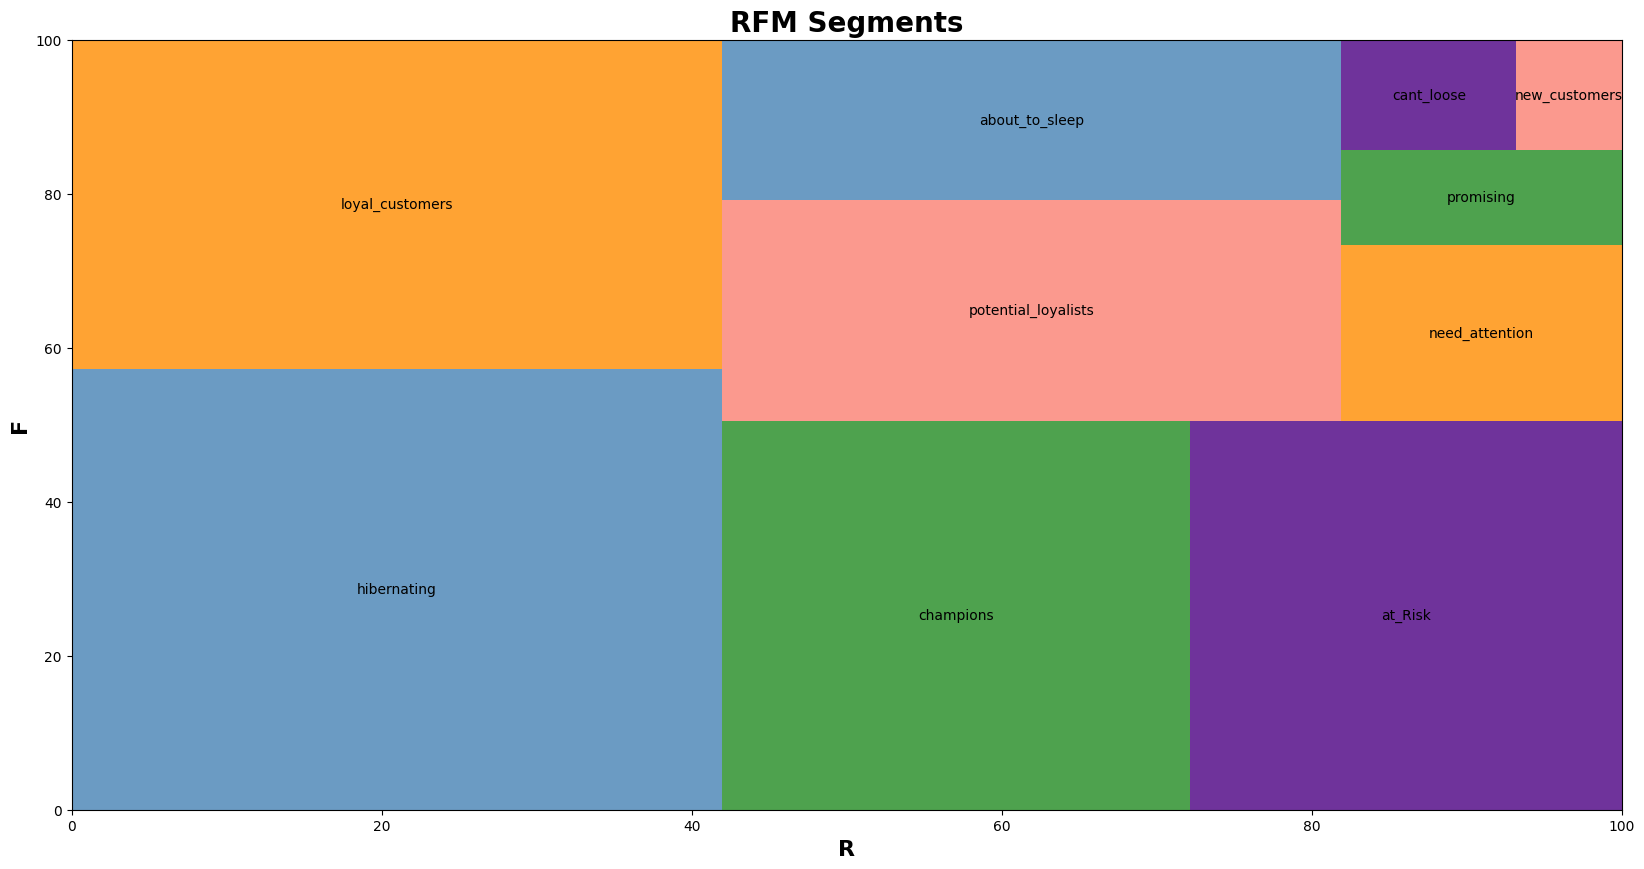

In [64]:
palette = ['steelblue', 'darkorange', 'forestgreen', 'indigo', 'salmon']
plt.figure(figsize=(20,10))
rfm["segment"].value_counts()
squarify.plot(sizes=rfm["segment"].value_counts().values, label=rfm["segment"].value_counts().index, alpha=.8, color=palette)
plt.ylabel("F", fontsize=16, fontweight="bold")
plt.xlabel("R", fontsize=16, fontweight="bold")
plt.title("RFM Segments",fontsize=20,fontweight="bold")
plt.show()

### Analisa Tingkat Segmen RFM

Berdasarkan segmentasi RFM tersebut dapat disimpulkan bahwa tingkat customer yang masuk ke dalam segmen **hibernating** dan juga **At Risk** cukup besar, sehingga perlu dilakukan upaya agar customer melakukan pembelian kembali dan tidak melakukan churn ke retail lainnya. Customer yang berada di segmen **potential loyalist** juga memiliki kecendrungan untuk berpindah ke segmen **loyal customer** jika retail menerapkan rencana yang tepat.

### Perbandingan Segmentasi RFM Berdasarkan Frekuensi

<Axes: title={'center': 'RFM Segments'}, xlabel='frequency', ylabel='segment'>

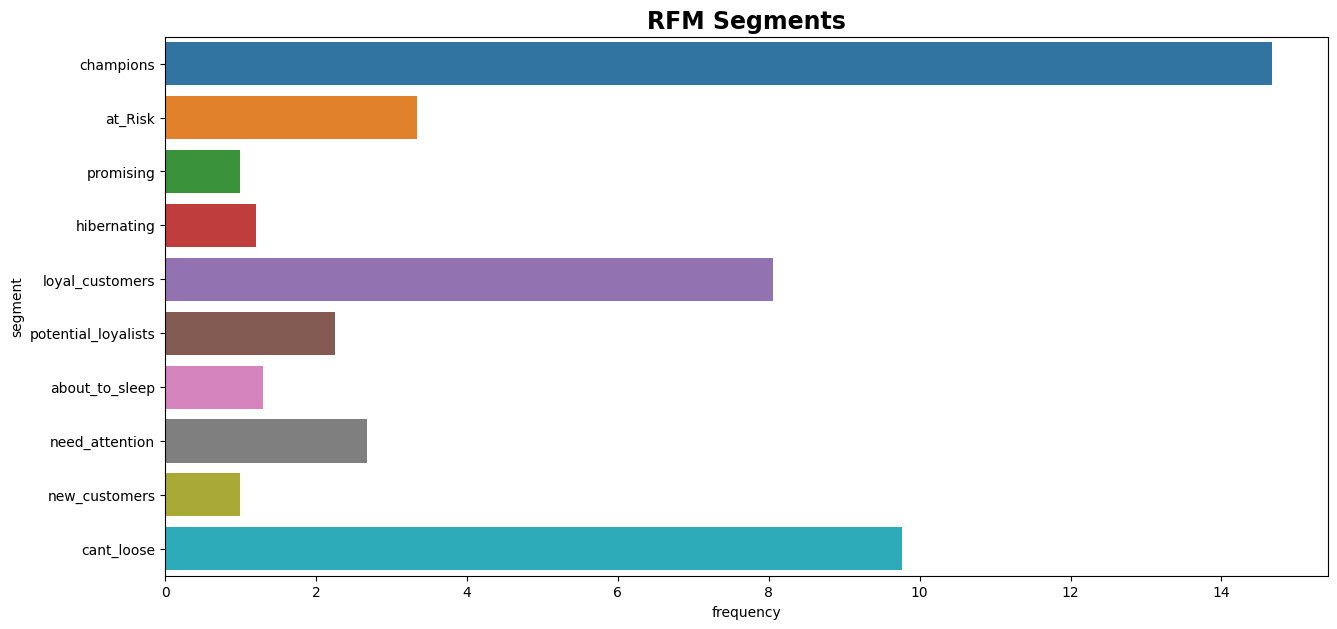

In [11]:
plt.figure(figsize=(15,7))
plt.title("RFM Segments",fontsize=17,fontweight="bold")
sns.barplot(x="frequency", y="segment", data=rfm, ci=None)

#### Analisa Perbandingan

Berdasarkan Frekuensi maka tingkat customer pada segmen **champions** dan juga **can't loose** memiliki frekuensi yang tinggi, begitu juga dengan customer pada segmen **loyal Customer**, hal ini membuktikan bahwa customer pada ketiga segmen tersebut sering melakukan transaksi pada retail. 

### Menghitung Customer Lifetime Value

In [12]:
def create_cltv_calculated(dataframe):
    # avg_order_value
    dataframe['avg_order_value'] = dataframe['monetary'] / dataframe['frequency']

    # purchase_frequency
    dataframe["purchase_frequency"] = dataframe['frequency'] / dataframe.shape[0]

    # repeat rate & churn rate
    repeat_rate = dataframe[dataframe.frequency > 1].shape[0] / dataframe.shape[0]
    churn_rate = 1 - repeat_rate

    # profit_margin
    dataframe['profit_margin'] = dataframe['monetary'] * 0.05

    # Customer Value
    dataframe['cv'] = (dataframe['avg_order_value'] * dataframe["purchase_frequency"])

    # Customer Lifetime Value
    dataframe['cltv'] = (dataframe['cv'] / churn_rate) * dataframe['profit_margin']

    # minmaxscaler
    scaler = MinMaxScaler(feature_range=(1, 100))
    scaler.fit(dataframe[["cltv"]])
    dataframe["cltv_calculated"] = scaler.transform(dataframe[["cltv"]])

    dataframe["cltv_calculated_segment"] = pd.qcut(dataframe["cltv_calculated"], 3, labels=["C", "B", "A"])

    dataframe = dataframe[["recency", "frequency", "monetary", "segment",
                           "cltv_calculated", "cltv_calculated_segment"]]

    return dataframe

**Customer Lifetime Value** diperoleh dari:
1. Average order value: Rata-rata nilai pesanan, dihitung dengan membagi nilai monetari (total nilai pembelian) dengan frekuensi pembelian pelanggan.

2. Purchase frequency: Frekuensi pembelian, dihitung dengan membagi frekuensi pembelian pelanggan dengan jumlah pelanggan dalam dataset.

3. Repeat rate & churn rate: Repeat rate adalah proporsi pelanggan yang melakukan pembelian lebih dari sekali, sedangkan churn rate adalah kebalikannya (1 - repeat rate).

4. Profit margin: Margin keuntungan yang diasumsikan, dihitung dengan mengalikan nilai monetari dengan 0.05 (asumsi margin keuntungan sebesar 5%).

5. Customer Value: Nilai pelanggan, dihitung dengan mengalikan avg_order_value dengan purchase_frequency.

#### Customer Lifetime Value

$$
\text{{CLTV}} = \left(\frac{{\text{{Customer Value}}}}{{\text{{churn rate}}}}\right) \times \text{{profit margin}}
$$


Pada Dataframe **CLTV** juga dilabeli berdasarkan hasil kalkulasi tingkat cltv tiap customer, terdapat tiga label yaitu A, B, dan C.

### Kalkulasi CLTV tiap Customer

In [65]:
rfm_cltv = create_cltv_calculated(rfm)
rfm_cltv.head()

,recency,frequency,monetary,segment,cltv_calculated,cltv_calculated_segment
CustomerID,,,,,,
12347.0,3,7,4299.80,champions,1.023671,A
12348.0,76,4,1797.24,at_Risk,1.004136,A
12349.0,19,1,1757.55,promising,1.003955,A
12350.0,311,1,334.40,hibernating,1.000143,C
12352.0,37,11,1545.41,loyal_customers,1.003058,A


Berdasarkan hasil kalkulasi dapat disimpulkan bahwa customer yang dalam segmen **hibernating** mendapat label **C**, sedangkan customer yang berada pada segmen **champions**, **at risk**, **promising**, dan **loyal customer** mendapat label A.

### Distribusi Kelas CLTV

Text(0.5, 1.0, 'Perbandinan Kelas CLTV')

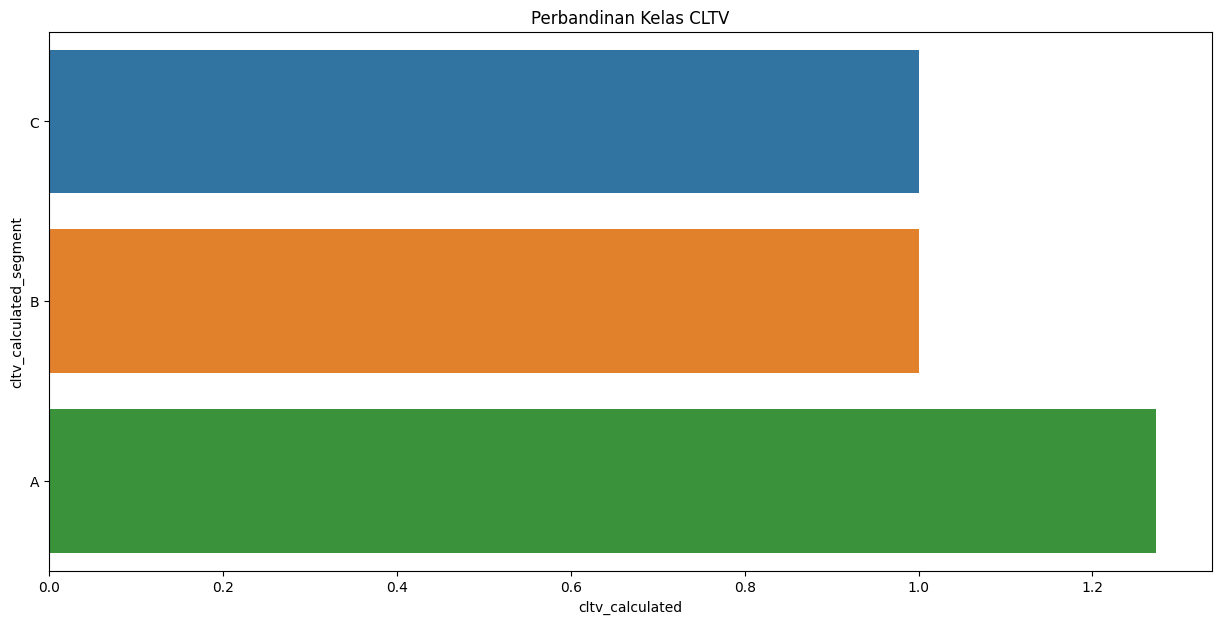

In [70]:
plt.figure(figsize=(15,7))
sns.barplot(x="cltv_calculated", y="cltv_calculated_segment", data=rfm_cltv, ci=None)
plt.title('Perbandinan Kelas CLTV')

#### Hasil Analisa

Berdasarkan grafik tersebut dapat disimpulkan bahwa distribusi kelas A lebih banyak dibandingkan distribusi kelas B dan Kelas C.

### Prediksi CLTV Untuk Periode 3 Bulan Kedepan 

In [66]:
def create_cltv_predicted(dataframe):
    today_date = datetime.datetime(2011, 12, 11)

    ## recency value customized
    rfm = dataframe.groupby('CustomerID').agg({'InvoiceDate': [lambda date: (date.max()-date.min()).days,
                                                                lambda date: (today_date - date.min()).days],
                                                'InvoiceNo': lambda num: num.nunique(),
                                                'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

    rfm.columns = rfm.columns.droplevel(0)

    ## recency_cltv_predicted
    rfm.columns = ['recency_cltv_predicted', 'T', 'frequency', 'monetary']

    ## basic monetary_avg
    rfm["monetary"] = rfm["monetary"] / rfm["frequency"]

    rfm.rename(columns={"monetary": "monetary_avg"}, inplace=True)
    
    ## recency_weekly_cltv_predicted
    rfm["recency_weekly_cltv_predicted"] = rfm["recency_cltv_predicted"] / 7
    rfm["T_weekly"] = rfm["T"] / 7



    # CONTROL
    rfm = rfm[rfm["monetary_avg"] > 0]

    ## recency filter
    rfm = rfm[(rfm['frequency'] > 1)]

    rfm["frequency"] = rfm["frequency"].astype(int)

    # BGNBD
    bgf = BetaGeoFitter(penalizer_coef=0.01)
    bgf.fit(rfm['frequency'],
            rfm['recency_weekly_cltv_predicted'],
            rfm['T_weekly'])
    
    # Gamma Gamma
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(rfm['frequency'], rfm['monetary_avg'])
    rfm["expected_average_profit"] = ggf.conditional_expected_average_profit(rfm['frequency'],
                                                                             rfm['monetary_avg'])
    # 6 months cltv_p
    cltv = ggf.customer_lifetime_value(bgf,
                                       rfm['frequency'],
                                       rfm['recency_weekly_cltv_predicted'],
                                       rfm['T_weekly'],
                                       rfm['monetary_avg'],
                                       time=3, #3 month prediction
                                       freq="W",
                                       discount_rate=0.01)

    rfm["cltv_predicted"] = cltv

    # minmaxscaler
    scaler = MinMaxScaler(feature_range=(1, 100))
    scaler.fit(rfm[["cltv_predicted"]])
    rfm["cltv_predicted"] = scaler.transform(rfm[["cltv_predicted"]])

    # rfm.fillna(0, inplace=True)

    # cltv_predicted_segment
    rfm["cltv_predicted_segment"] = pd.qcut(rfm["cltv_predicted"], 3, labels=["C", "B", "A"])

    ## recency_cltv_predicted, recency_weekly_cltv_predicted
    rfm = rfm[["recency_cltv_predicted", "T", "monetary_avg", "recency_weekly_cltv_predicted", "T_weekly",
               "expected_average_profit","cltv_predicted", "cltv_predicted_segment"]]


    return rfm

Menggunakan ggf dan bgf untuk melakukan prediksi cltv 

### Hasil Prediksi CLTV

In [67]:
rfm_cltv_predicted = create_cltv_predicted(df)
rfm_cltv_predicted.head()

,recency_cltv_predicted,T,monetary_avg,recency_weekly_cltv_predicted,T_weekly,expected_average_profit,cltv_predicted,cltv_predicted_segment
CustomerID,,,,,,,,
12347.0,365,368,614.257143,52.142857,52.571429,636.266443,2.820810,A
12348.0,282,359,449.310000,40.285714,51.285714,478.503262,1.856192,B
12352.0,260,297,140.491818,37.142857,42.428571,143.917610,1.709261,B
12356.0,302,326,937.143333,43.142857,46.571429,1018.625720,2.687728,A
12358.0,149,151,584.030000,21.285714,21.571429,664.385998,2.604079,A


Text(0.5, 1.0, 'Hasil Prediksi CLTV')

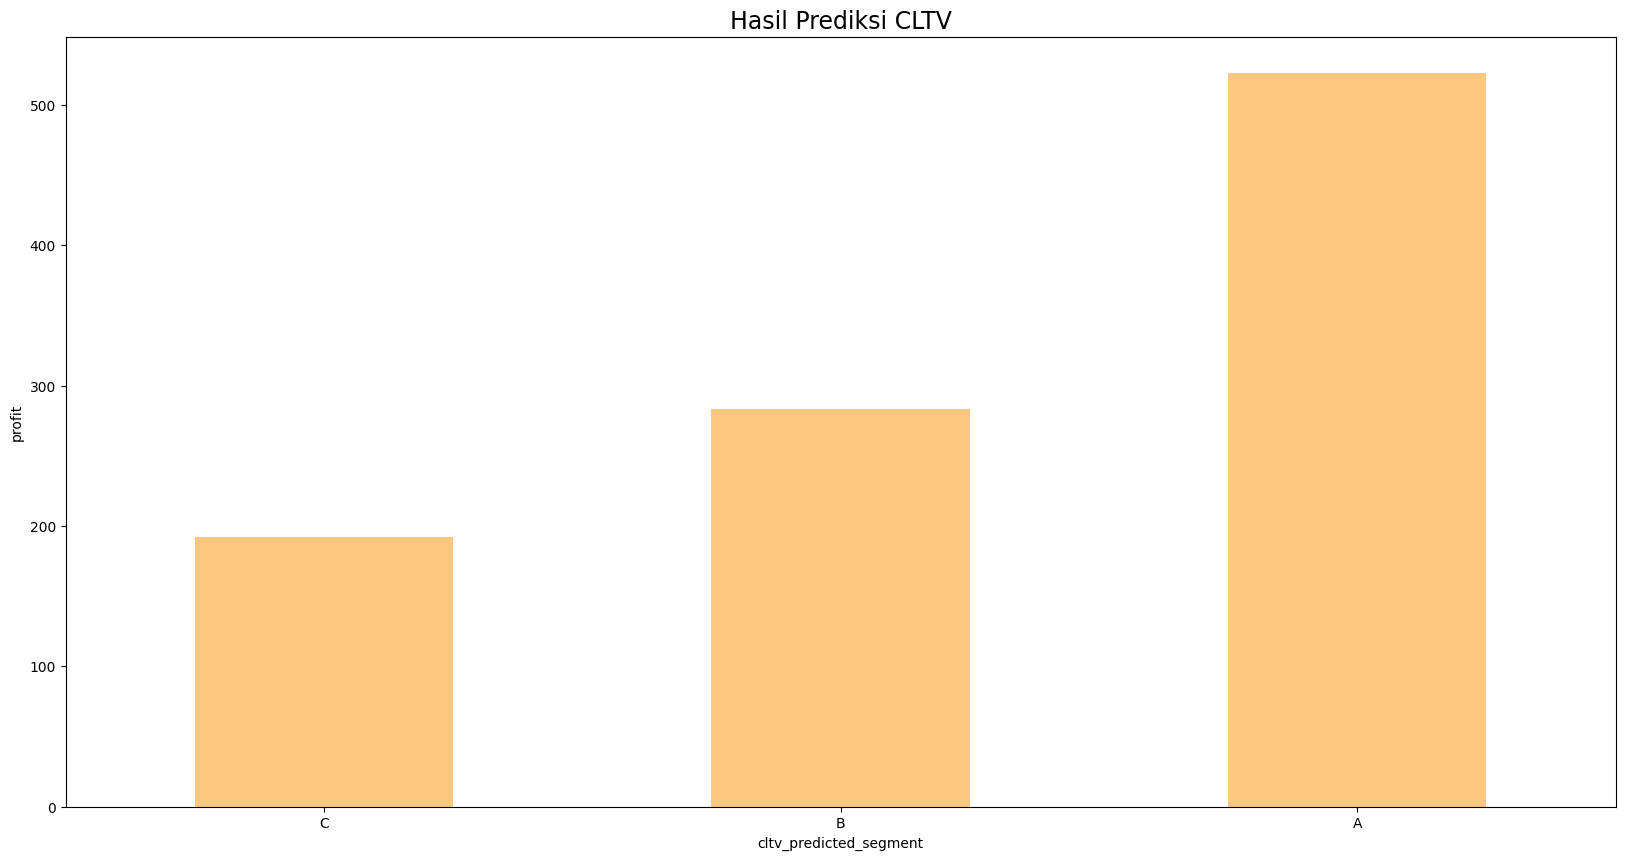

In [69]:
plt.figure(figsize=(20,10))
rfm_cltv_predicted.groupby('cltv_predicted_segment').agg('expected_average_profit').mean().plot(kind='bar', colormap='copper_r');

plt.ylabel("profit");
plt.xticks(rotation=360);
plt.title('Hasil Prediksi CLTV', fontsize=17)

#### Hasil Analisa

Hasil dari prediksi menunjukan bahwa terdapat pertumbuhan pada segmen A, sehingga retail dapat fokus ke retensi pelanggan dan melakukan manajemen penjualan yang sesuai.

### CRM

In [19]:
crm_final = rfm_cltv.merge(rfm_cltv_predicted, on="CustomerID", how="left")
crm_final.head(10)

,recency,frequency,monetary,segment,cltv_calculated,cltv_calculated_segment,recency_cltv_predicted,T,monetary_avg,recency_weekly_cltv_predicted,T_weekly,expected_average_profit,cltv_predicted,cltv_predicted_segment
CustomerID,,,,,,,,,,,,,,
12347.0,1,7,4299.80,champions,1.023671,A,365.0,368.0,614.257143,52.142857,52.571429,636.266443,2.820810,A
12348.0,74,4,1797.24,at_Risk,1.004136,A,282.0,359.0,449.310000,40.285714,51.285714,478.503262,1.856192,B
12349.0,17,1,1757.55,promising,1.003955,A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350.0,309,1,334.40,hibernating,1.000143,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12352.0,35,11,1545.41,loyal_customers,1.003058,A,260.0,297.0,140.491818,37.142857,42.428571,143.917610,1.709261,B
12353.0,203,1,89.00,hibernating,1.000010,C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12354.0,231,1,1079.40,hibernating,1.001492,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12355.0,213,1,459.40,hibernating,1.000270,B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12356.0,21,3,2811.43,potential_loyalists,1.010120,A,302.0,326.0,937.143333,43.142857,46.571429,1018.625720,2.687728,A


In [20]:
crm_final.sort_values(by="monetary_avg", ascending=False).head(10)

,recency,frequency,monetary,segment,cltv_calculated,cltv_calculated_segment,recency_cltv_predicted,T,monetary_avg,recency_weekly_cltv_predicted,T_weekly,expected_average_profit,cltv_predicted,cltv_predicted_segment
CustomerID,,,,,,,,,,,,,,
15749.0,234,4,21535.90,at_Risk,1.593811,A,97.0,333.0,5383.975000,13.857143,47.571429,5723.097480,2.673877,A
12415.0,23,26,121957.13,loyal_customers,20.043044,A,313.0,338.0,4690.658846,44.714286,48.285714,4733.837644,47.304317,A
18102.0,-1,62,256438.49,champions,85.195408,A,366.0,368.0,4136.104677,52.285714,52.571429,4151.993588,89.937200,A
16000.0,1,3,12393.70,potential_loyalists,1.196664,A,0.0,3.0,4131.233333,0.000000,0.428571,4485.914927,54.477411,A
12435.0,78,2,7829.89,hibernating,1.078493,A,188.0,268.0,3914.945000,26.857143,38.285714,4441.747209,7.268634,A
14646.0,0,77,278071.58,champions,100.000000,A,353.0,355.0,3611.319221,50.428571,50.714286,3622.487374,100.000000,A
14088.0,9,14,49771.69,champions,4.171661,A,312.0,323.0,3555.120714,44.571429,46.142857,3616.443513,22.099352,A
17450.0,7,55,187482.17,champions,46.003048,A,359.0,368.0,3408.766727,51.285714,52.571429,3423.547134,65.975969,A
12590.0,189,3,9861.38,at_Risk,1.124508,A,20.0,212.0,3287.126667,2.857143,30.285714,3569.609521,1.461446,B


Melalui metode CRM, retail dapat melakukan manajemen hubungan dengan customer berdasarkan nilai rata-rata pembeliannya. Retail harus menyesuaikan dari bagian pemasaran dan benefit yang dapat diperoleh oleh customer berdasarkan urutannya.